In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from salt_utils import get_train_test_salt_data
import matplotlib.pyplot as plt
from dotted.collection import DottedDict
import numpy as np
import pickle
import random
import tqdm

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)


def plot_metrics(metric_logs):
  for metric_log in metric_logs:
    plt.plot(metric_log['epoch'], metric_log['metric'], label=metric_log['label'])
  plt.xlabel('Epochs')
  plt.ylabel('Metric')
  plt.legend()
  plt.show()
  
def train(model, epochs=1):
  for e in tqdm.trange(epochs, desc='epochs'):
    metric = 0
    samples_seen = 0
    model.net.train()
    for img, mask in model.loader:
      model.optim.zero_grad()
      loss = F.binary_cross_entropy_with_logits(model.net(img.cuda()), mask.cuda())
      metric += loss.item()
      loss.backward()
      model.optim.step()
      samples_seen += model.batch_size
    model.train_metric_log['epoch'].append(model.epochs_trained)
    model.train_metric_log['metric'].append(metric / samples_seen)
    
    if model.epochs_trained % model.eval_test == 0:
      metric = 0
      samples_seen = 0
      model.net.eval()
      with torch.no_grad():
        for img, mask in model.test_loader:
          loss = F.binary_cross_entropy_with_logits(model.net(img.cuda()), mask.cuda())
          metric += loss.item()
          samples_seen += model.batch_size
      model.test_metric_log['epoch'].append(model.epochs_trained)
      model.test_metric_log['metric'].append(metric / samples_seen)
    model.epochs_trained += 1
      
def train_mixup(model, epochs=1):
  for e in tqdm.trange(epochs, desc='epochs'):
    metric = 0
    samples_seen = 0
    model.net.train()
    for img, mask in model.loader:
      model.optim.zero_grad()
      loss = F.binary_cross_entropy_with_logits(model.net(img.cuda()), mask.cuda())
      metric += loss.item()
      loss.backward()
      model.optim.step()
      samples_seen += model.batch_size
    model.train_metric_log['epoch'].append(model.epochs_trained)
    model.train_metric_log['metric'].append(metric / samples_seen)
    
    if model.epochs_trained % model.eval_test == 0:
      metric = 0
      samples_seen = 0
      model.net.eval()
      with torch.no_grad():
        for img, mask in model.test_loader:
          loss = F.binary_cross_entropy_with_logits(model.net(img.cuda()), mask.cuda())
          metric += loss.item()
          samples_seen += model.batch_size
      model.test_metric_log['epoch'].append(model.epochs_trained)
      model.test_metric_log['metric'].append(metric / samples_seen)
    model.epochs_trained += 1      

def conv(in_c, out_c):
  return nn.Sequential(
    nn.Conv2d(in_c, out_c, 3, padding=1, bias=False),
    nn.BatchNorm2d(out_c),
    nn.ELU(inplace=True),
    nn.Conv2d(out_c, out_c, 3, padding=1, bias=False),
    nn.BatchNorm2d(out_c),
    nn.ELU(inplace=True),
  )

class UNet(nn.Module):
  def __init__(self):
    super(UNet, self).__init__()
    self.down1 = conv(  2,  16) # (  2, 128, 128) --> ( 16, 128, 128)
    self.down2 = conv( 16,  32) # ( 16,  64,  64) --> ( 32,  64,  64)
    self.down3 = conv( 32,  64) # ( 32,  32,  32) --> ( 64,  32,  32)
    self.down4 = conv( 64, 128) # ( 64,  16,  16) --> (128,  16,  16)
    self.down5 = conv(128, 256) # (128,   8,   8) --> (256,   8,   8)
    self.up1   = conv(384, 128) # (256,  16,  16) --> (128,  16,  16)
    self.up2   = conv(192,  64) # (128,  32,  32) --> ( 64,  32,  32)
    self.up3   = conv( 96,  32) # ( 64,  64,  64) --> ( 32,  64,  64)
    self.up4   = conv( 48,  16) # ( 32, 128, 128) --> ( 16, 128, 128)
    self.tail  = nn.Conv2d(16, 1, 1)
    self.downpool = nn.MaxPool2d(kernel_size=2)
    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

  def forward(self, x):
    x_down_128 = self.down1(x)
    x_down_64  = self.down2(self.downpool(x_down_128))
    x_down_32  = self.down3(self.downpool(x_down_64))
    x_down_16  = self.down4(self.downpool(x_down_32))
    x_down_8   = self.down5(self.downpool(x_down_16))
    x_up = self.up1(torch.cat([self.upsample(x_down_8), x_down_16], dim=1))
    x_up = self.up2(torch.cat([self.upsample(x_up), x_down_32], dim=1))
    x_up = self.up3(torch.cat([self.upsample(x_up), x_down_64], dim=1))
    x_up = self.up4(torch.cat([self.upsample(x_up), x_down_128],  dim=1))
    return self.tail(x_up)

In [2]:
set_seed(38)

train_data, test_data = get_train_test_salt_data('./data/train/images/', 
                                                 './data/train/masks/', 
                                                 './data/train/depths.csv', 
                                                 test_frac=.2)
model = DottedDict()
model['batch_size'] = 48
model['net'] = UNet().cuda()
model['optim'] = optim.Adam(model.net.parameters(), lr=0.005)
model['loader'] = DataLoader(train_data, model.batch_size, True, num_workers=2, drop_last=True)
model['loader_other'] = DataLoader(train_data, model.batch_size, True, num_workers=2, drop_last=True)
model['test_loader'] = DataLoader(test_data, model.batch_size, True, num_workers=2, drop_last=True)
model['epochs_trained'] = 0
model['eval_test'] = 2
model['train_metric_log'] = {'label':'Train Loss', 'epoch':[], 'metric':[]}
model['test_metric_log'] = {'label':'Test Loss', 'epoch':[], 'metric':[]}

In [3]:
train(model, 250)

epochs: 100%|██████████| 250/250 [1:43:17<00:00, 24.79s/it]


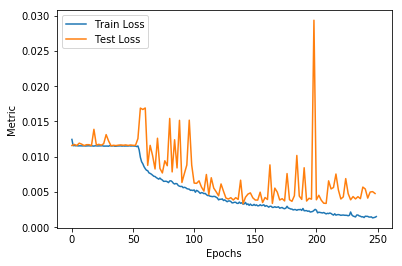

In [6]:
plot_metrics([model.train_metric_log, model.test_metric_log])

In [ ]:
#pickle.dump([{**model['train_metric_log']}, {**model['test_metric_log']}], 
#            open('./history/unet_normal_aug_seed38.hist', 'wb'))